In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity, adjust_gamma
import pandas as pd
from pyxem.utils import indexation_utils as iutls
import copy
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

def subtract_background_dog(z, sigma_min, sigma_max):        ###################### background subtract for diffraction image
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    


def process_image(image, threshold = 2, gamma = 0.6):                # Gamma correction
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 0.5, 10)
    # smooth the image
    image = gaussian_filter(image, sigma=1.5)
    # remove low intensity pixels
    image[image < threshold] = 0
    # change the gamma of the images
    image = adjust_gamma(image, gamma)
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image


from scipy.ndimage import interpolation
from diffsims.libraries.diffraction_library import load_DiffractionLibrary, _get_library_entry_from_angles

############################################### self written correlation function for matching

def correlation(image, simu):         # normalized by simulation intensity, anchored for same image
    return np.sum(np.multiply(image, simu)) / np.linalg.norm(simu)/ np.linalg.norm(image)

def correlation_map(image, lib):
    simu_img_lib = lib['pt']['simulations']
    num = simu_img_lib.shape[0]
    rotation = np.arange(0,180,2)
    total_confid = np.zeros([num, len(rotation)])
    for i in tqdm(range(num)):
        simu_img = simu_img_lib[i].get_diffraction_pattern(size = 120, sigma = 2)
        for j, angle in enumerate(rotation):
            simu_img_rotated = interpolation.rotate(simu_img, angle, reshape=False)
            total_confid[i, j] = correlation(image, simu_img_rotated)
    return total_confid
            
    

def correlation_map_no_rotation(image, library, n_largest):
    top_matches = np.empty((len(library), n_largest, 3), dtype='object')

    for phase_index, library_entry in enumerate(library.values()):
        orientations = library_entry['orientations']
        pixel_coords = library_entry['pixel_coords']
        intensities = library_entry['intensities']
        
        or_saved, corr_saved = np.empty((n_largest, 3)), np.zeros((n_largest, 1))
        for (or_local, px_local, int_local) in zip(orientations, pixel_coords, intensities):
            image_intensities = image[px_local[:, 1], px_local[:, 0]]
            corr_local = np.sum(np.multiply(image_intensities, int_local)) / int_local.sum()
                  
            if corr_local > np.min(corr_saved):
                or_saved[np.argmin(corr_saved)] = or_local
                corr_saved[np.argmin(corr_saved)] = corr_local

            combined_array = np.hstack((or_saved, corr_saved))
            combined_array = combined_array[np.flip(combined_array[:, 3].argsort())]  
            top_matches[phase_index, :, 0] = phase_index
            top_matches[phase_index, :, 2] = combined_array[:, 3]  
            for i in np.arange(n_largest):
                top_matches[phase_index, i, 1] = combined_array[i, :3] 

    return top_matches.reshape(-1, 3)

def correlation_map_fast(image, library):
    rotation_match = np.zeros([3*90,4])
    for j,angle in enumerate(range(0,180,2)):
        image_rotate = interpolation.rotate(image, angle, reshape=False)
        matching = correlation_map_no_rotation(image_rotate, library, 3)
        for i in range(len(matching)):
            matching[i][1][0] = angle
            rotation_match[j*3+i,:3] = matching[i][1]
            rotation_match[j*3+i,3] = matching[i][-1]
    return rotation_match


def find_nth_peaks(confid_curve, threshold = 0.9, max_n = 3): 
    valleys_ind = argrelextrema(confid_curve, np.less)[0][0]
    confid_curve_shift = np.roll(confid_curve, valleys_ind)
    peaks, _ = find_peaks(confid_curve_shift)
    max_one = confid_curve_shift[peaks].argmax()
    peaks_above_threshold = confid_curve_shift[peaks] > confid_curve_shift[peaks][max_one]*threshold
    peaks_above_threshold = min(3, peaks_above_threshold.sum())
    peak_heights = confid_curve_shift[peaks]
    return peaks[np.argsort(peak_heights)[::-1][:peaks_above_threshold]]-valleys_ind
        
def correlation_map_fast_1d_dataset(imageset, library, plot_interval = 5, threshold = 2, gamma = 0.4, threshold_peak=0.8):
    match_result = []
    for image_num, image in enumerate(tqdm(imageset)):
        rotation_match = correlation_map_fast(process_image(image), library)
        rotation_match[:,-1] = gaussian_filter(rotation_match[:,-1], 3)
#         plt.figure()
#         plt.plot(rotation_match[:,-1])
        peaks = find_nth_peaks(rotation_match[:,-1], threshold = threshold_peak)
        match_result.append(rotation_match[peaks])
        print(rotation_match[peaks])
        
        ################################ plot module
        if plot_interval != 0:
            if image_num % plot_interval == 0:
                plt.figure(figsize=(9,3))
                plt.subplot(1,4,1)
                plt.imshow(image)
                plt.subplot(1,4,2)
                num_of_label = 0
                Euler_angle = (0, rotation_match[peaks][num_of_label][1], rotation_match[peaks][num_of_label][2])
                library_entry = _get_library_entry_from_angles(library,'pt',Euler_angle)
                rotation = -1*rotation_match[peaks][num_of_label][0]
                simu_img_rotated = interpolation.rotate(library['pt']['simulations'][library_entry].get_diffraction_pattern(shape = (120, 120), sigma = 2), rotation, reshape=False)
                plt.imshow(process_image(image))
                plt.imshow(simu_img_rotated,alpha=rescale_intensity(simu_img_rotated,out_range=(0,1)),cmap='Reds')
                plt.subplot(1,4,3)
                plt.imshow(simu_img_rotated,cmap='Reds')
                plt.subplot(1,4,4)
                plt.plot(rotation_match[:,-1])
        ################################
    return match_result


def correlation_map_fast_2d_dataset(imageset, library, plot_interval = 5,verbose=True, threshold = 2, gamma = 0.4, threshold_peak=0.8):
    dim_x, dim_y = imageset.shape[:2]
    Match_results_all = pd.DataFrame(np.zeros([dim_x*dim_y, 14]), columns = ['X','Y','Euler1_candidate1','Euler2_candidate1','Euler3_candidate1', 'confid1', 
                                             'Euler1_candidate2','Euler2_candidate2','Euler3_candidate2','confid2', 
                                             'Euler1_candidate3','Euler2_candidate3','Euler3_candidate3', 'confid3'])
    for row_num, image_row in enumerate(tqdm(imageset) if verbose else imageset):
        for col_num, image in enumerate(tqdm(image_row)):
            rotation_match = correlation_map_fast(process_image(image, threshold = threshold, gamma = gamma), library)
            rotation_match[:,-1] = gaussian_filter(rotation_match[:,-1], 3)
    #         plt.figure()
    #         plt.plot(rotation_match[:,-1])
            peaks = find_nth_peaks(rotation_match[:,-1], threshold = threshold_peak)
#             match_result.append(rotation_match[peaks])
            print(rotation_match[peaks])
            ################################ update Match_results_all
            Match_results_all['X'][row_num*dim_y+col_num] = row_num
            Match_results_all['Y'][row_num*dim_y+col_num] = col_num
            for i in range(len(rotation_match[peaks])):
                Match_results_all.iloc[row_num*dim_y+col_num, i*4+2:i*4+6] = rotation_match[peaks][i]
            ################################ plot module
            if plot_interval != 0:
                if col_num % plot_interval == 0:
                    plt.figure(figsize=(9,3))
                    plt.subplot(1,4,1)
                    plt.imshow(image)
                    plt.subplot(1,4,2)
                    num_of_label = 0
                    Euler_angle = (0, rotation_match[peaks][num_of_label][1], rotation_match[peaks][num_of_label][2])
                    library_entry = _get_library_entry_from_angles(library,'pt',Euler_angle)
                    rotation = -1*rotation_match[peaks][num_of_label][0]
                    simu_img_rotated = interpolation.rotate(library['pt']['simulations'][library_entry].get_diffraction_pattern(shape = (120, 120), sigma = 2), rotation, reshape=False)
                    plt.imshow(process_image(image))
                    plt.imshow(simu_img_rotated,alpha=rescale_intensity(simu_img_rotated,out_range=(0,1)),cmap='Reds')
                    plt.subplot(1,4,3)
                    plt.imshow(simu_img_rotated,cmap='Reds')
                    plt.subplot(1,4,4)
                    plt.plot(rotation_match[:,-1])
            ################################
    return Match_results_all
             
                
############################################   clean diff simulation sparse spot matrix
diff_lib_pt = load_DiffractionLibrary("data/Pt_lib_0.3deg_0.1me.pickle", True)
for i in tqdm(range(len(diff_lib_pt['pt']['pixel_coords']))):
    inrange_0 = np.bitwise_and(diff_lib_pt['pt']['pixel_coords'][i][:,0] < 120, diff_lib_pt['pt']['pixel_coords'][i][:,0] > 0)
    diff_lib_pt['pt']['pixel_coords'][i] = diff_lib_pt['pt']['pixel_coords'][i][inrange_0]
    diff_lib_pt['pt']['intensities'][i] = diff_lib_pt['pt']['intensities'][i][inrange_0]
    inrange_1 = np.bitwise_and(diff_lib_pt['pt']['pixel_coords'][i][:,1] < 120, diff_lib_pt['pt']['pixel_coords'][i][:,1] > 0)
    diff_lib_pt['pt']['pixel_coords'][i] = diff_lib_pt['pt']['pixel_coords'][i][inrange_1]
    diff_lib_pt['pt']['intensities'][i] = diff_lib_pt['pt']['intensities'][i][inrange_1]
    diff_lib_pt['pt']['intensities'][i] = adjust_gamma(diff_lib_pt['pt']['intensities'][i], 0.2)          ##### adjust gamma encourage matching with more spots

diff_lib_pt_mirror = copy.deepcopy(diff_lib_pt)
for i in tqdm(range(len(diff_lib_pt_mirror['pt']['pixel_coords']))):
    diff_lib_pt_mirror['pt']['pixel_coords'][i][:,0] = 120 - diff_lib_pt_mirror['pt']['pixel_coords'][i][:,0]


In [47]:
num_of_dataset = 3
data_file = hs.load(("data/"+str(num_of_dataset)+".hspy"),lazy=True)
result, phasedict = iutls.index_dataset_with_template_rotation(data_file.inav[:,:],
                                                    diff_lib_pt, n_best = 10, intensity_transform_function = process_image)
orientation = result['orientation'][:,:,0,:]
for i in tqdm(range(orientation.shape[0])):  
    for j in range(orientation.shape[1]):
        if orientation[i, j, 1] < 0:
            orientation[i, j, 1:3] *= -1
            orientation[i, j, 0] -= 180

dim_x, dim_y = orientation.shape[0], orientation.shape[1]
pixel_index = pd.DataFrame(np.zeros([dim_x*dim_y, 42]), columns = ['X','Y','Euler1_candidate1','Euler2_candidate1','Euler3_candidate1', 'confid1', 
                                             'Euler1_candidate2','Euler2_candidate2','Euler3_candidate2','confid2', 
                                             'Euler1_candidate3','Euler2_candidate3','Euler3_candidate3', 'confid3', 
                                             'Euler1_candidate4','Euler2_candidate4','Euler3_candidate4', 'confid4', 
                                             'Euler1_candidate5','Euler2_candidate5','Euler3_candidate5', 'confid5', 
                                             'Euler1_candidate6','Euler2_candidate6','Euler3_candidate6', 'confid6', 
                                             'Euler1_candidate7','Euler2_candidate7','Euler3_candidate7', 'confid7', 
                                             'Euler1_candidate8','Euler2_candidate8','Euler3_candidate8', 'confid8', 
                                             'Euler1_candidate9','Euler2_candidate9','Euler3_candidate9', 'confid9', 
                                             'Euler1_candidate10','Euler2_candidat10','Euler3_candidate10', 'confid10'])
for i in tqdm(range(dim_x)):
    for j in range(dim_y):
        pixel_index['X'][i*dim_y + j] = i
        pixel_index['Y'][i*dim_y + j] = j
        for k in range(1,11):
            pixel_index['Euler1_candidate'+str(k)][i*dim_y + j], \
            pixel_index['Euler2_candidate'+str(k)][i*dim_y + j], \
            pixel_index['Euler3_candidate'+str(k)][i*dim_y + j], \
            pixel_index['confid'+str(k)][i*dim_y + j] = \
            *orientation[i,j], result['correlation'][i,j,k]

with open(f"data/index_mapping_{num_of_dataset}_10.txt", 'w') as f:
    for i in range(14):
        f.write('\n')
    pixel_index.sort_values(by = ['X', 'Y']).to_csv(f, sep=' ', index=False)
    f.write("\n")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.50it/s]


In [ ]:
num_of_dataset = 3
data_file = hs.load(("data/"+str(num_of_dataset)+".hspy"),lazy=True)
result, phasedict = iutls.index_dataset_with_template_rotation(data_file.inav[:,:],
                                                    diff_lib_pt, n_best = 3, intensity_transform_function = process_image)

orientation = result['orientation'][:,:,0,:]
for i in tqdm(range(orientation.shape[0])):
    for j in range(orientation.shape[1]):
        if orientation[i, j, 1] < 0:
            orientation[i, j, 1:3] *= -1
            orientation[i, j, 0] -= 180

dim_x, dim_y = orientation.shape[0], orientation.shape[1]
pixel_index = pd.DataFrame(np.zeros([dim_x*dim_y, 11]),columns = ['Phase','X','Y','Bands','Error','Euler1','Euler2','Euler3','MAD','BC','BS'])
for i in tqdm(range(dim_x)):
    for j in range(dim_y):
        pixel_index['X'][i*dim_y + j] = i
        pixel_index['Y'][i*dim_y + j] = j
        pixel_index['Euler1'][i*dim_y + j], pixel_index['Euler2'][i*dim_y + j], pixel_index['Euler3'][i*dim_y + j], pixel_index['MAD'][i*dim_y + j] = \
                                        *orientation[i,j], result['correlation'][i,j,0]

with open(f"data/index_mapping_{num_of_dataset}.txt", 'w') as f:
    for i in range(14):
        f.write('\n')
    pixel_index.sort_values(by = ['X', 'Y']).to_csv(f, sep=' ', index=False)
    f.write("\n")

# Visualization

In [11]:
from orix.projections import StereographicProjection
from orix.quaternion.rotation import Rotation
from orix.vector.vector3d import Vector3d
def ori_to_vec(eulers):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    rotations_regular =  Rotation.from_euler(np.deg2rad(eulers))
    return rotations_regular*Vector3d.zvector()

def get_ipf_color(vectors):
    # the following column vectors should map onto R [100], G [010], B[001], i.e. the identity. So the inverse of 
    # this matrix maps the beam directions onto the right color vector
    color_corners = np.array([[0, 1/np.sqrt(2), 1/np.sqrt(3)],
                              [0, 0, 1/np.sqrt(3)],
                              [1, 1/np.sqrt(2), 1/np.sqrt(3)]])
    color_corners = np.array([[0, 1, 1],
                              [0, 0, 1],
                              [1, 1, 1]])
    color_mapper = np.linalg.inv(color_corners)

    # a bit of wrangling
    data_sol = to_fundamental(vectors.data)
    flattened = data_sol.reshape(np.product(data_sol.shape[:-1]), 3).T
    rgb_mapped = np.dot(color_mapper, flattened)
    rgb_mapped = np.abs(rgb_mapped / rgb_mapped.max(axis=0)).T
    rgb_mapped = rgb_mapped.reshape(data_sol.shape)
    return rgb_mapped

def to_fundamental(data_sol):
    data_sol = np.abs(data_sol)
    data_sol = np.sort(data_sol, axis=-1)
    column = data_sol[...,0].copy()
    data_sol[..., 0] = data_sol[...,1]
    data_sol[..., 1] = column
    return data_sol

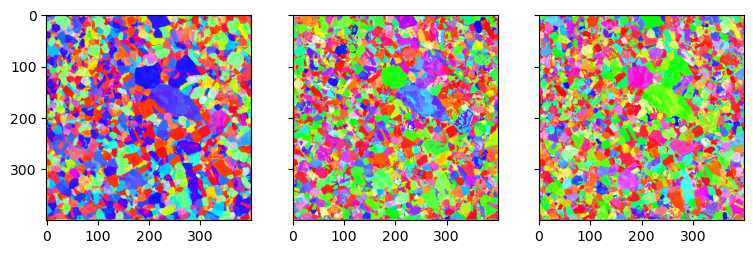

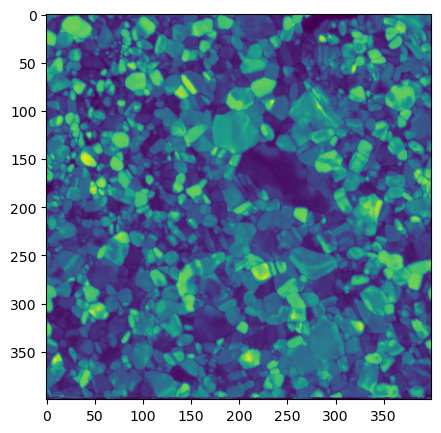

In [13]:
for num_of_dataset in range(10):
    data = pd.read_csv(f"data/index_mapping_{num_of_dataset}.txt",
                skiprows=14,
                sep=" ",
               )
    x = data["X"].unique()
    y = data["Y"].unique()
    n_x = x.shape[0]
    n_y = y.shape[0]
    eulers = np.array(data[["Euler1", "Euler2", "Euler3"]]).reshape((n_y, n_x, 3))
    solution_astar = Rotation.from_euler(np.deg2rad(eulers))
    confid = np.array(data[["MAD"]]).reshape((n_y, n_x))
    vectorz = Vector3d([0, 0, 1]).unit
    vectory = Vector3d([0, 1, 0]).unit
    vectorx = Vector3d([1, 0, 0]).unit

    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(9, 3))
    ax[0].imshow(get_ipf_color(solution_astar*vectorz))
    ax[1].imshow(get_ipf_color(solution_astar*vectorx))
    ax[2].imshow(get_ipf_color(solution_astar*vectory))
    plt.savefig(f"data/index_mapping_origin_{num_of_dataset}.jpeg",dpi = 300)

    plt.figure(figsize=(5, 5))
    plt.imshow(confid)
    plt.savefig(f"data/index_mapping_confid_{num_of_dataset}.jpeg",dpi = 300)